# XGBoost Regression – Untuned (GPU Compatible)

This notebook trains two **XGBoost regression models**:
- One using **all high-variance features** (`VarianceThreshold`)
- One using the **top 30 features** selected with `RandomForestRegressor`

The objective is to provide a strong baseline without any hyperparameter tuning, but with GPU acceleration.

e:\_SoftEng\_BeCode\real-estate-price-predictor\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TEST_MODE is ON – reduced data and iterations.


e:\_SoftEng\_BeCode\real-estate-price-predictor\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:16:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
e:\_SoftEng\_BeCode\real-estate-price-predictor\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [15:16:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
e:\_SoftEng\_BeCode\real-estate-price-predictor\.venv\Lib\site-packages\xgboost\core.py:729: UserWarning: [15:16:33] WARNING: C:\actions-runner\_work\xgboost\x

Evaluation – XGBoost CV (All Features) [TEST]
  MAE:  45,377.91 €
  RMSE: 63,950.86 €
  R²:   0.9063
----------------------------------------
Evaluation – XGBoost CV (Top RF Features) [TEST]
  MAE:  46,946.03 €
  RMSE: 66,134.78 €
  R²:   0.8998
----------------------------------------
Model evaluation for 'XGBoost CV (All Features) [TEST]' already exists. Skipping log.
Model evaluation for 'XGBoost CV (Top RF Features) [TEST]' already exists. Skipping log.
Evaluation Summary (All Features):
=== Model Evaluation Summary ===


e:\_SoftEng\_BeCode\real-estate-price-predictor\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [15:16:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


,id,timestamp,model,dataset,experiment,cleaning_version_id,mae,rmse,r2,type,rank_r2,rmse/mae,best
0,162,2025-06-29 14:20:14,Linear Regression (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,Linear Regression (All Features),202506291419,76 898.76 €,109 935.46 €,0.723000,Linear,11,1.430000,
1,163,2025-06-29 14:20:43,Random Forest (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,Random Forest (All Features),202506291419,68 324.02 €,101 428.25 €,0.764200,Tree,7,1.480000,
2,164,2025-06-29 14:20:53,Random Forest (Top 10 Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,Random Forest (Top 10 Features),202506291419,71 734.61 €,106 140.03 €,0.741800,Tree,8,1.480000,
3,165,2025-06-29 14:22:04,XGBoost + Optuna CV (All Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,XGBoost with Optuna (All Features) [TEST],202506291419,3 891.83 €,7 847.80 €,0.998600,Boosting,1,2.020000,✓
4,166,2025-06-29 14:22:04,XGBoost + Optuna CV (Top RF Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,XGBoost with Optuna (Top RF Features) [TEST],202506291419,54 915.96 €,77 673.21 €,0.861800,Boosting,6,1.410000,
5,167,2025-06-29 14:23:16,CatBoost + Optuna CV (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,CatBoost with Optuna (All Features),202506291419,51 719.81 €,73 206.37 €,0.877200,Boosting,4,1.420000,
6,168,2025-06-29 14:23:16,CatBoost + Optuna CV (Top RF Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,CatBoost with Optuna (Top RF Features),202506291419,53 774.71 €,76 478.44 €,0.866000,Boosting,5,1.420000,
7,169,2025-06-29 14:27:17,XGBoost CV (All Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,XGBoost Untuned (All Features) [TEST],202506291419,45 377.91 €,63 950.86 €,0.906300,Boosting,2,1.410000,
8,170,2025-06-29 14:27:17,XGBoost CV (Top RF Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,XGBoost Untuned (Top RF Features) [TEST],202506291419,46 946.03 €,66 134.78 €,0.899800,Boosting,3,1.410000,
9,171,2025-06-29 14:51:55,CatBoost (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,CatBoost Baseline (All Features),202506291419,76 301.82 €,109 286.49 €,0.726400,Boosting,10,1.430000,



👉 Best model based on R²: XGBoost + Optuna CV (All Features) [TEST] ✓
Evaluation Summary (Top RF Features):
=== Model Evaluation Summary ===


,id,timestamp,model,dataset,experiment,cleaning_version_id,mae,rmse,r2,type,rank_r2,rmse/mae,best
0,162,2025-06-29 14:20:14,Linear Regression (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,Linear Regression (All Features),202506291419,76 898.76 €,109 935.46 €,0.723000,Linear,11,1.430000,
1,163,2025-06-29 14:20:43,Random Forest (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,Random Forest (All Features),202506291419,68 324.02 €,101 428.25 €,0.764200,Tree,7,1.480000,
2,164,2025-06-29 14:20:53,Random Forest (Top 10 Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,Random Forest (Top 10 Features),202506291419,71 734.61 €,106 140.03 €,0.741800,Tree,8,1.480000,
3,165,2025-06-29 14:22:04,XGBoost + Optuna CV (All Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,XGBoost with Optuna (All Features) [TEST],202506291419,3 891.83 €,7 847.80 €,0.998600,Boosting,1,2.020000,✓
4,166,2025-06-29 14:22:04,XGBoost + Optuna CV (Top RF Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,XGBoost with Optuna (Top RF Features) [TEST],202506291419,54 915.96 €,77 673.21 €,0.861800,Boosting,6,1.410000,
5,167,2025-06-29 14:23:16,CatBoost + Optuna CV (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,CatBoost with Optuna (All Features),202506291419,51 719.81 €,73 206.37 €,0.877200,Boosting,4,1.420000,
6,168,2025-06-29 14:23:16,CatBoost + Optuna CV (Top RF Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,CatBoost with Optuna (Top RF Features),202506291419,53 774.71 €,76 478.44 €,0.866000,Boosting,5,1.420000,
7,169,2025-06-29 14:27:17,XGBoost CV (All Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,XGBoost Untuned (All Features) [TEST],202506291419,45 377.91 €,63 950.86 €,0.906300,Boosting,2,1.410000,
8,170,2025-06-29 14:27:17,XGBoost CV (Top RF Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,XGBoost Untuned (Top RF Features) [TEST],202506291419,46 946.03 €,66 134.78 €,0.899800,Boosting,3,1.410000,
9,171,2025-06-29 14:51:55,CatBoost (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,CatBoost Baseline (All Features),202506291419,76 301.82 €,109 286.49 €,0.726400,Boosting,10,1.430000,



👉 Best model based on R²: XGBoost + Optuna CV (All Features) [TEST] ✓
Diagnostics (All Features):


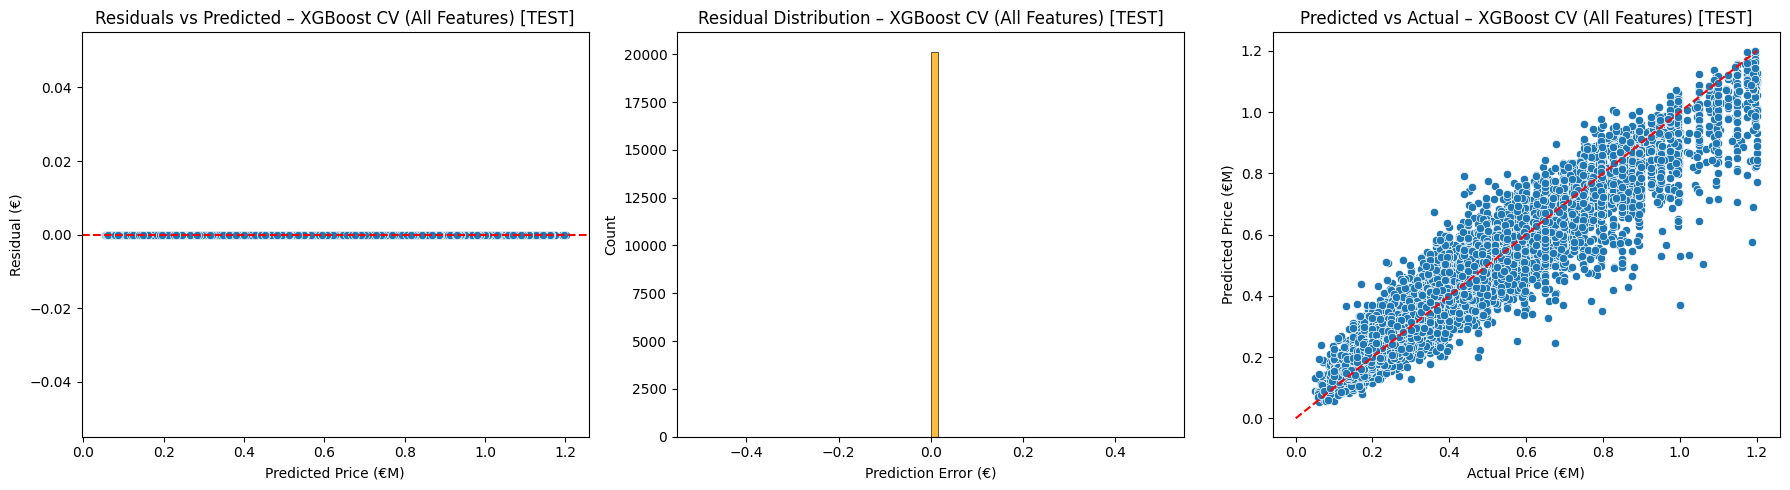

Diagnostics (Top RF Features):


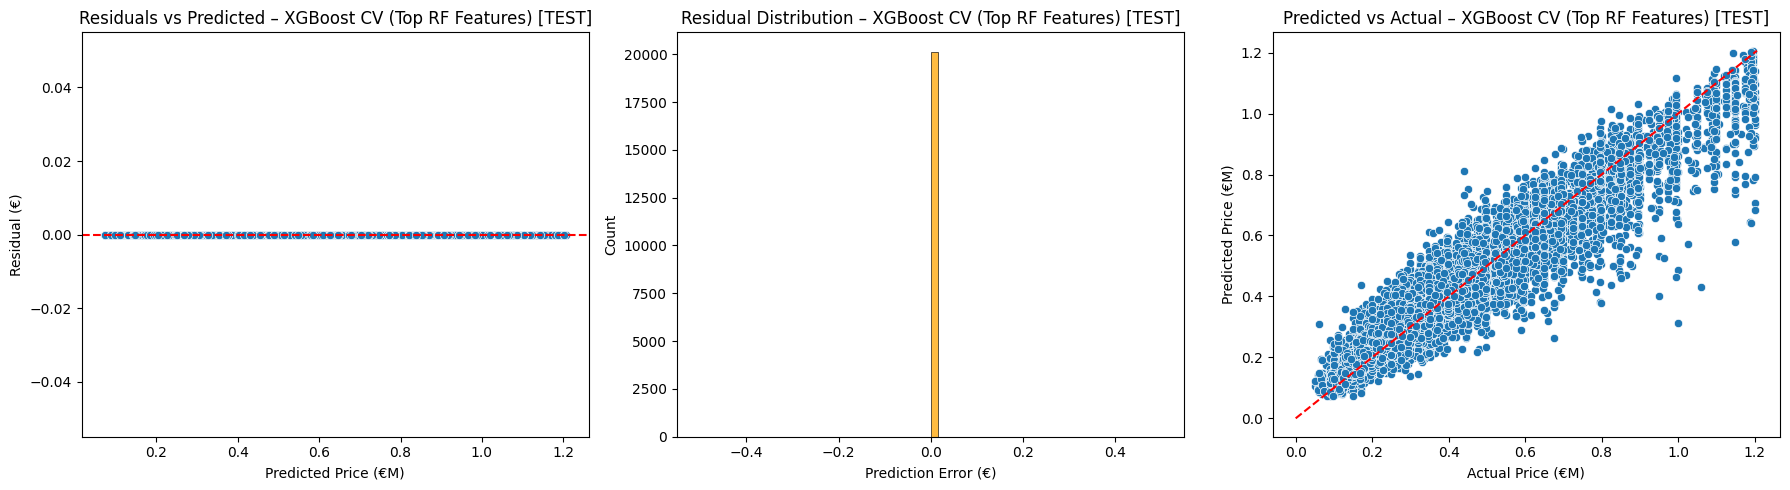

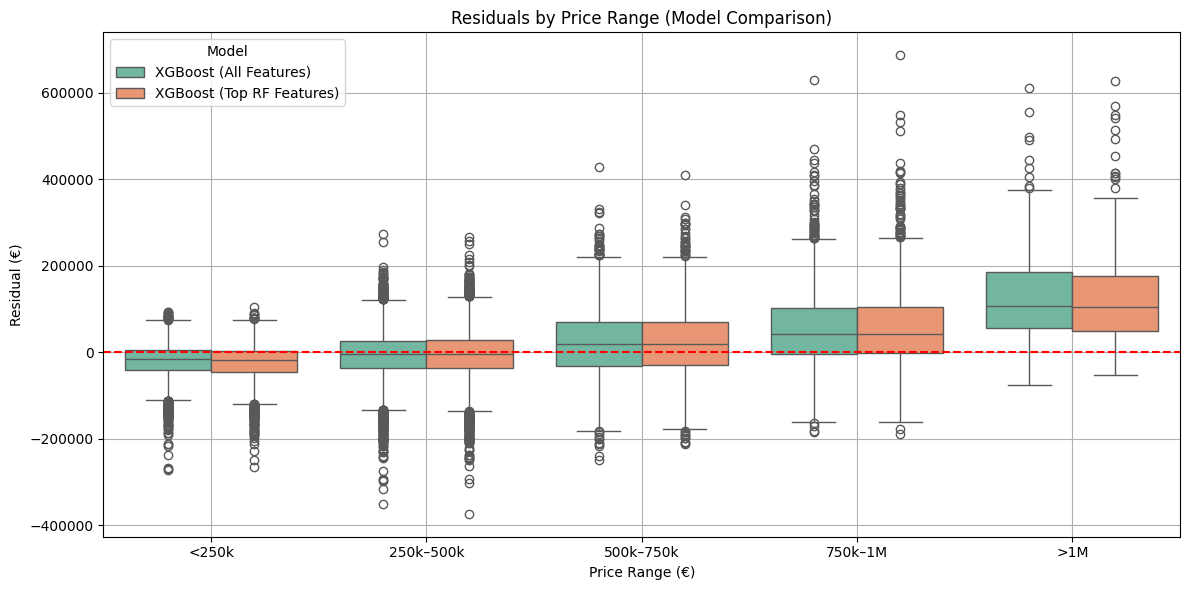

In [1]:
import sys, os
# Add the project root to the Python path
project_root = os.path.abspath("../..")
sys.path.append(project_root)

import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold

from utils.constants import ML_READY_DATA_FILE, TEST_MODE
from utils.data_loader import DataLoader
from utils.model_evaluator import ModelEvaluator
from utils.experiment_tracker import ExperimentTracker
from utils.model_visualizer import ModelVisualizer


# === RMSE helper ===
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


# === Mode info ===
if TEST_MODE:
    print("TEST_MODE is ON – reduced data and iterations.")
else:
    print("TEST_MODE is OFF – full training.")


# === Load dataset ===
loader = DataLoader(ML_READY_DATA_FILE)
df = loader.load_data()
X = df.drop(columns=["price"])
y = df["price"]

# === Variance threshold ===
selector = VarianceThreshold(threshold=0.01)
selector.fit(X)
X_reduced = X.loc[:, selector.get_support()]

# === Feature importance (Top 30 from Random Forest) ===
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_reduced, y)
importances = rf.feature_importances_
top_features = pd.Series(importances, index=X_reduced.columns).sort_values(ascending=False).head(30).index.tolist()
X_top = X_reduced[top_features]

# === Define untuned XGBoost params ===
params = {
    "objective": "reg:squarederror",
    "random_state": 42,
    "n_estimators": 100 if TEST_MODE else 400,
    "tree_method": "gpu_hist",  # GPU acceleration
    "n_jobs": -1
}

# === Train XGBoost – All Features ===
model_all = xgb.XGBRegressor(**params)
model_all.fit(X_reduced, y)
y_pred_all = model_all.predict(X_reduced)

# === Train XGBoost – Top Features ===
model_top = xgb.XGBRegressor(**params)
model_top.fit(X_top, y)
y_pred_top = model_top.predict(X_top)

# === Evaluation ===
suffix = " [TEST]" if TEST_MODE else ""
evaluator_all = ModelEvaluator(f"XGBoost CV (All Features){suffix}")
mae_all, rmse_all, r2_all = evaluator_all.evaluate(y, y_pred_all)

evaluator_top = ModelEvaluator(f"XGBoost CV (Top RF Features){suffix}")
mae_top, rmse_top, r2_top = evaluator_top.evaluate(y, y_pred_top)

# === Log results ===
tracker = ExperimentTracker()

df_metrics_all = tracker.log_and_get_evaluations(
    model=f"XGBoost CV (All Features){suffix}",
    experiment=f"XGBoost Untuned (All Features){suffix}",
    mae=mae_all,
    rmse=rmse_all,
    r2=r2_all,
)

df_metrics_top = tracker.log_and_get_evaluations(
    model=f"XGBoost CV (Top RF Features){suffix}",
    experiment=f"XGBoost Untuned (Top RF Features){suffix}",
    mae=mae_top,
    rmse=rmse_top,
    r2=r2_top,
)

# === Display results ===
print("Evaluation Summary (All Features):")
evaluator_all.display_model_summary(df_metrics_all)

print("Evaluation Summary (Top RF Features):")
evaluator_top.display_model_summary(df_metrics_top)

# === Visual diagnostics ===
print("Diagnostics (All Features):")
ModelVisualizer(model_all, X_reduced, y, model_name=f"XGBoost CV (All Features){suffix}").plot_all_diagnostics()

print("Diagnostics (Top RF Features):")
ModelVisualizer(model_top, X_top, y, model_name=f"XGBoost CV (Top RF Features){suffix}").plot_all_diagnostics()

ModelEvaluator.plot_price_range_residuals_side_by_side(
    y, y_pred_all, y_pred_top,
    model_names=("XGBoost (All Features)", "XGBoost (Top RF Features)")
)


# 🎯 XGBoost Regression with Optuna Hyperparameter Tuning

This notebook trains two XGBoost regression models on real estate data, with **hyperparameter tuning using Optuna**. It includes all stages from loading the data to model diagnostics.

## Data Preparation

- Load the cleaned ML-ready dataset from a CSV file using `DataLoader`.
- Drop the target variable `price` to separate `X` and `y`.
- Apply `VarianceThreshold` to remove low-variance features (threshold = 0.01).
- Use a `RandomForestRegressor` to rank feature importance.
- Select the **top 30 most important features** for one of the models.


## Hyperparameter Tuning (Optuna)

Define the function `tune_xgboost_with_optuna(...)` that:

- Runs an Optuna optimization loop.
- Evaluates model performance with **5-Fold Cross-Validation**.
- Minimizes the **Root Mean Squared Error (RMSE)**.

### Tuned Hyperparameters:

- `max_depth`
- `learning_rate`
- `n_estimators`
- `subsample`, `colsample_bytree`
- `reg_alpha`, `reg_lambda`
- `min_child_weight`, `gamma`



## Train Final Models

Two models are trained:

- One using **all filtered features**
- One using the **top 30 features**

Each is trained using the **best parameters** found by Optuna.

---

## Evaluation

Models are evaluated using:

- `MAE`: Mean Absolute Error  
- `RMSE`: Root Mean Squared Error  
- `R<sup>2</sup>`: Coefficient of determination  

Results are logged with `ExperimentTracker`.



## Diagnostics

- Summary tables displayed with `ModelEvaluator`
- Residuals & diagnostic plots from `ModelVisualizer`
- Optionally, **SHAP values** can be plotted to understand feature importance



## Test Mode (Optional)

When `TEST_MODE = True`, the pipeline uses:

- A smaller dataset  
- Fewer Optuna trials (`n_trials = 3`)  

To speed up execution and debugging.


TEST_MODE is ON – running in test mode (reduced data, fewer trials).


[I 2025-06-29 15:16:42,083] A new study created in memory with name: no-name-f2887b32-d24b-40c5-b31f-8fb3e275cb56
[I 2025-06-29 15:16:46,084] Trial 0 finished with value: 107953.6805826519 and parameters: {'max_depth': 6, 'learning_rate': 0.011048062542713594, 'n_estimators': 300, 'subsample': 0.6733811379310656, 'colsample_bytree': 0.728116119438166, 'reg_alpha': 0.7954953666340365, 'reg_lambda': 0.020517127839737692, 'min_child_weight': 8.425594529719167, 'gamma': 1.6431964920494297}. Best is trial 0 with value: 107953.6805826519.
[I 2025-06-29 15:16:51,850] Trial 1 finished with value: 101481.6456210316 and parameters: {'max_depth': 10, 'learning_rate': 0.29316502642312803, 'n_estimators': 238, 'subsample': 0.8205100291188727, 'colsample_bytree': 0.65253391451567, 'reg_alpha': 0.7438696381116809, 'reg_lambda': 0.9059133986507506, 'min_child_weight': 3.3570462733625903, 'gamma': 0.7510054640892688}. Best is trial 1 with value: 101481.6456210316.
[I 2025-06-29 15:16:59,220] Trial 2 fi

Evaluation – XGBoost + Optuna CV (All Features)
  MAE:  44,516.70 €
  RMSE: 63,007.02 €
  R²:   0.9090
----------------------------------------
Evaluation – XGBoost + Optuna CV (Top RF Features)
  MAE:  12,837.59 €
  RMSE: 18,506.43 €
  R²:   0.9922
----------------------------------------
Model evaluation for 'XGBoost + Optuna CV (All Features) [TEST]' already exists. Skipping log.
Model evaluation for 'XGBoost + Optuna CV (Top RF Features) [TEST]' already exists. Skipping log.
Evaluation Summary (All Features):
=== Model Evaluation Summary ===


,id,timestamp,model,dataset,experiment,cleaning_version_id,mae,rmse,r2,type,rank_r2,rmse/mae,best
0,162,2025-06-29 14:20:14,Linear Regression (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,Linear Regression (All Features),202506291419,76 898.76 €,109 935.46 €,0.723000,Linear,11,1.430000,
1,163,2025-06-29 14:20:43,Random Forest (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,Random Forest (All Features),202506291419,68 324.02 €,101 428.25 €,0.764200,Tree,7,1.480000,
2,164,2025-06-29 14:20:53,Random Forest (Top 10 Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,Random Forest (Top 10 Features),202506291419,71 734.61 €,106 140.03 €,0.741800,Tree,8,1.480000,
3,165,2025-06-29 14:22:04,XGBoost + Optuna CV (All Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,XGBoost with Optuna (All Features) [TEST],202506291419,3 891.83 €,7 847.80 €,0.998600,Boosting,1,2.020000,✓
4,166,2025-06-29 14:22:04,XGBoost + Optuna CV (Top RF Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,XGBoost with Optuna (Top RF Features) [TEST],202506291419,54 915.96 €,77 673.21 €,0.861800,Boosting,6,1.410000,
5,167,2025-06-29 14:23:16,CatBoost + Optuna CV (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,CatBoost with Optuna (All Features),202506291419,51 719.81 €,73 206.37 €,0.877200,Boosting,4,1.420000,
6,168,2025-06-29 14:23:16,CatBoost + Optuna CV (Top RF Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,CatBoost with Optuna (Top RF Features),202506291419,53 774.71 €,76 478.44 €,0.866000,Boosting,5,1.420000,
7,169,2025-06-29 14:27:17,XGBoost CV (All Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,XGBoost Untuned (All Features) [TEST],202506291419,45 377.91 €,63 950.86 €,0.906300,Boosting,2,1.410000,
8,170,2025-06-29 14:27:17,XGBoost CV (Top RF Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,XGBoost Untuned (Top RF Features) [TEST],202506291419,46 946.03 €,66 134.78 €,0.899800,Boosting,3,1.410000,
9,171,2025-06-29 14:51:55,CatBoost (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,CatBoost Baseline (All Features),202506291419,76 301.82 €,109 286.49 €,0.726400,Boosting,10,1.430000,



👉 Best model based on R²: XGBoost + Optuna CV (All Features) [TEST] ✓
Evaluation Summary (Top RF Features):
=== Model Evaluation Summary ===


,id,timestamp,model,dataset,experiment,cleaning_version_id,mae,rmse,r2,type,rank_r2,rmse/mae,best
0,162,2025-06-29 14:20:14,Linear Regression (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,Linear Regression (All Features),202506291419,76 898.76 €,109 935.46 €,0.723000,Linear,11,1.430000,
1,163,2025-06-29 14:20:43,Random Forest (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,Random Forest (All Features),202506291419,68 324.02 €,101 428.25 €,0.764200,Tree,7,1.480000,
2,164,2025-06-29 14:20:53,Random Forest (Top 10 Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,Random Forest (Top 10 Features),202506291419,71 734.61 €,106 140.03 €,0.741800,Tree,8,1.480000,
3,165,2025-06-29 14:22:04,XGBoost + Optuna CV (All Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,XGBoost with Optuna (All Features) [TEST],202506291419,3 891.83 €,7 847.80 €,0.998600,Boosting,1,2.020000,✓
4,166,2025-06-29 14:22:04,XGBoost + Optuna CV (Top RF Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,XGBoost with Optuna (Top RF Features) [TEST],202506291419,54 915.96 €,77 673.21 €,0.861800,Boosting,6,1.410000,
5,167,2025-06-29 14:23:16,CatBoost + Optuna CV (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,CatBoost with Optuna (All Features),202506291419,51 719.81 €,73 206.37 €,0.877200,Boosting,4,1.420000,
6,168,2025-06-29 14:23:16,CatBoost + Optuna CV (Top RF Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,CatBoost with Optuna (Top RF Features),202506291419,53 774.71 €,76 478.44 €,0.866000,Boosting,5,1.420000,
7,169,2025-06-29 14:27:17,XGBoost CV (All Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,XGBoost Untuned (All Features) [TEST],202506291419,45 377.91 €,63 950.86 €,0.906300,Boosting,2,1.410000,
8,170,2025-06-29 14:27:17,XGBoost CV (Top RF Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,XGBoost Untuned (Top RF Features) [TEST],202506291419,46 946.03 €,66 134.78 €,0.899800,Boosting,3,1.410000,
9,171,2025-06-29 14:51:55,CatBoost (All Features),immoweb_real_estate_cleaned_for_ml_20250629_1419.csv,CatBoost Baseline (All Features),202506291419,76 301.82 €,109 286.49 €,0.726400,Boosting,10,1.430000,



👉 Best model based on R²: XGBoost + Optuna CV (All Features) [TEST] ✓
Diagnostics (All Features):


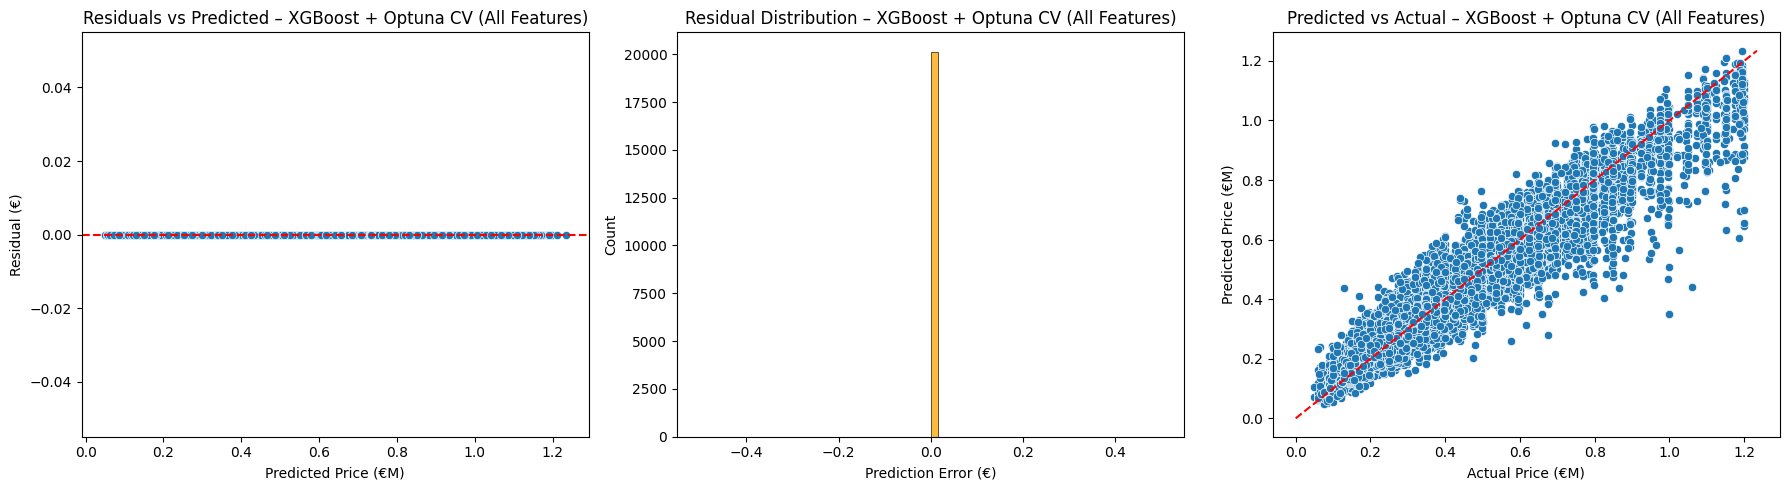

Diagnostics (Top RF Features):


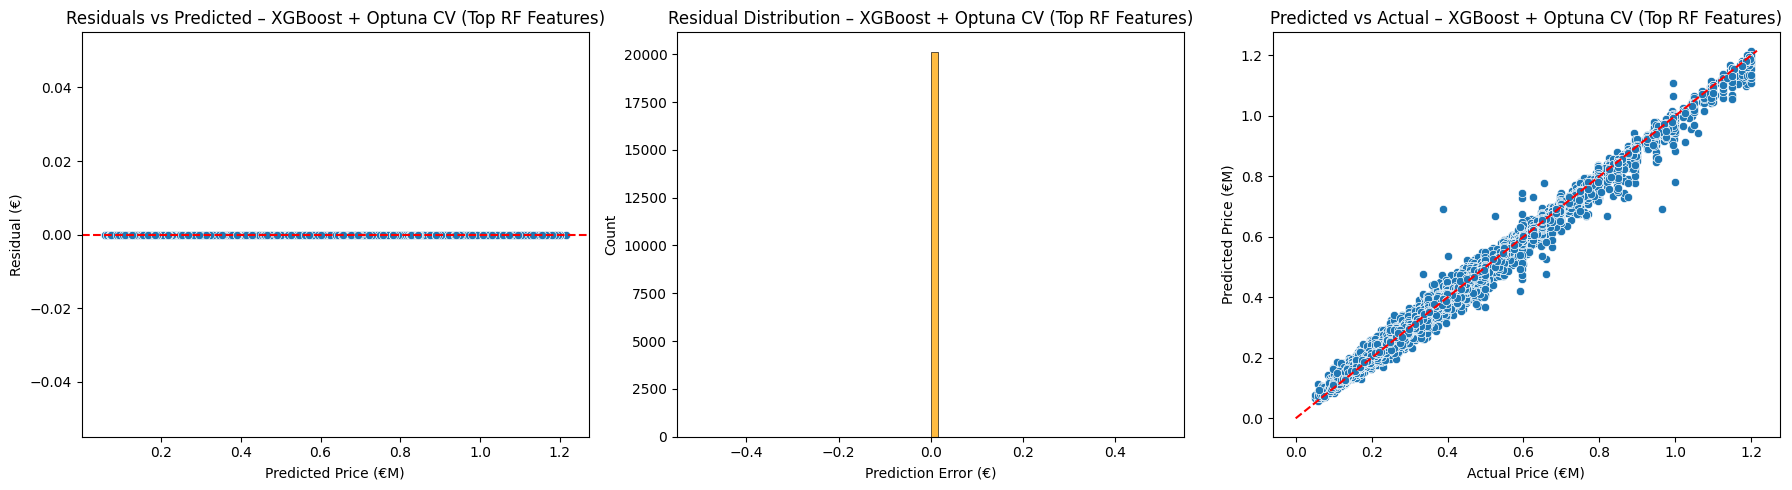

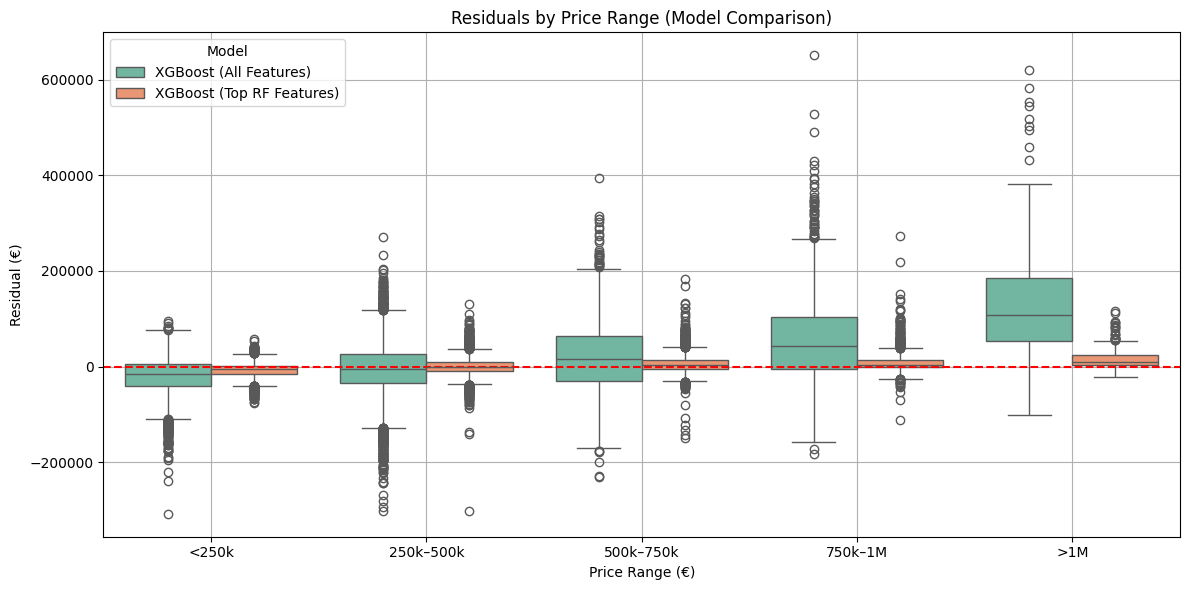

'\nModelEvaluator.plot_shap_comparison_beeswarm(\n    model_all=model_all,\n    x_all=X_reduced,\n    model_top=model_top,\n    x_top=X_top\n)\n'

In [2]:
import sys, os

# Add the project root to the Python path
project_root = os.path.abspath("../..") 
sys.path.append(project_root)

import optuna
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from utils.constants import ML_READY_DATA_FILE, TEST_MODE
from utils.data_loader import DataLoader
from utils.model_evaluator import ModelEvaluator
from utils.experiment_tracker import ExperimentTracker
from utils.model_visualizer import ModelVisualizer


import numpy as np
import pandas as pd


# Root Mean Squared Error
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

if TEST_MODE:
    print("TEST_MODE is ON – running in test mode (reduced data, fewer trials).")
else:
    print("TEST_MODE is OFF – full training is active.")

# Step 1: Load and clean dataset
loader = DataLoader(ML_READY_DATA_FILE)
df = loader.load_data()

X = df.drop(columns=["price"])
y = df["price"]

# Remove low-variance features
selector = VarianceThreshold(threshold=0.01)
selector.fit(X)  # Fit the selector on the full dataset
X_reduced = X.loc[:, selector.get_support()]

# Step 3: Extract top 30 features using Random Forest
rf_model_all = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model_all.fit(X_reduced, y)

importances = rf_model_all.feature_importances_
feature_ranking = pd.Series(importances, index=X_reduced.columns).sort_values(ascending=False)
top_features = feature_ranking.head(30).index.tolist()
X_top = X_reduced[top_features]

# Step 4: Define Optuna tuning function
def tune_xgboost_with_optuna(X_data, y_data, n_trials=50):
    def objective(trial):
        params = {
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "n_estimators": trial.suggest_int("n_estimators", 100, 800),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
            "min_child_weight": trial.suggest_float("min_child_weight", 1, 10),
            "gamma": trial.suggest_float("gamma", 0, 5),
        }
        model = xgb.XGBRegressor(**params, objective="reg:squarederror", random_state=42, n_jobs=-1)
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = -cross_val_score(model, X_data, y_data, scoring="neg_root_mean_squared_error", cv=cv)
        return scores.mean()

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)
    return study
 

# Step 5: Tune and train both models
n_trials = 3 if TEST_MODE else 50

study_all = tune_xgboost_with_optuna(X_reduced, y, n_trials=n_trials)
model_all = xgb.XGBRegressor(**study_all.best_params, objective="reg:squarederror", random_state=42, n_jobs=-1)
model_all.fit(X_reduced, y)
y_pred_all = model_all.predict(X_reduced)

study_top = tune_xgboost_with_optuna(X_top, y, n_trials=n_trials)
model_top = xgb.XGBRegressor(**study_top.best_params, objective="reg:squarederror", random_state=42, n_jobs=-1)
model_top.fit(X_top, y)
y_pred_top = model_top.predict(X_top)

# Step 6: Evaluate models
evaluator_all = ModelEvaluator("XGBoost + Optuna CV (All Features)")
mae_all, rmse_all, r2_all = evaluator_all.evaluate(y, y_pred_all)

evaluator_top = ModelEvaluator("XGBoost + Optuna CV (Top RF Features)")
mae_top, rmse_top, r2_top = evaluator_top.evaluate(y, y_pred_top)

# Step 7: Log results
# Ajout du suffixe TEST si nécessaire
suffix = " [TEST]" if TEST_MODE else ""

# Init tracker
tracker = ExperimentTracker()

# Log modèle All Features
df_metrics_all = tracker.log_and_get_evaluations(
    model=f"XGBoost + Optuna CV (All Features){suffix}",
    experiment=f"XGBoost with Optuna (All Features){suffix}",
    mae=mae_all,
    rmse=rmse_all,
    r2=r2_all,
)

# Log modèle Top RF Features
df_metrics_top = tracker.log_and_get_evaluations(
    model=f"XGBoost + Optuna CV (Top RF Features){suffix}",
    experiment=f"XGBoost with Optuna (Top RF Features){suffix}",
    mae=mae_top,
    rmse=rmse_top,
    r2=r2_top,
)

# Step 8: Display evaluation summary
print("Evaluation Summary (All Features):")
evaluator_all.display_model_summary(df_metrics_all)

print("Evaluation Summary (Top RF Features):")
evaluator_top.display_model_summary(df_metrics_top)

# Step 9: Visual diagnostics
print("Diagnostics (All Features):")
visualizer_all = ModelVisualizer(model_all, X_reduced, y, model_name="XGBoost + Optuna CV (All Features)")
visualizer_all.plot_all_diagnostics()

print("Diagnostics (Top RF Features):")
visualizer_top = ModelVisualizer(model_top, X_top, y, model_name="XGBoost + Optuna CV (Top RF Features)")
visualizer_top.plot_all_diagnostics()


ModelEvaluator.plot_price_range_residuals_side_by_side(
    y,
    y_pred_all,
    y_pred_top,
    model_names=("XGBoost (All Features)", "XGBoost (Top RF Features)")
)

"""
ModelEvaluator.plot_shap_comparison_beeswarm(
    model_all=model_all,
    x_all=X_reduced,
    model_top=model_top,
    x_top=X_top
)
"""



In [3]:
import sys, os

# Add the project root to the Python path
project_root = os.path.abspath("../..")
sys.path.append(project_root)

import joblib
from datetime import datetime
from utils.constants import TEST_MODE, MODELS_DIR

# Create timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

# Add suffix if in TEST mode
suffix = "_TEST" if TEST_MODE else ""

# Define subdirectory for .pkl files
PKL_DIR = os.path.join(MODELS_DIR, "pkl")
os.makedirs(PKL_DIR, exist_ok=True)

# Build filenames
filename_all = f"xgboost_optuna_all_{timestamp}{suffix}.pkl"
filename_top = f"xgboost_optuna_top30_{timestamp}{suffix}.pkl"

# Save models
joblib.dump(model_all, os.path.join(PKL_DIR, filename_all))
joblib.dump(model_top, os.path.join(PKL_DIR, filename_top))

print(f"[✔] Models saved to '{PKL_DIR}' as:\n - {filename_all}\n - {filename_top}")


[✔] Models saved to 'e:\_SoftEng\_BeCode\real-estate-price-predictor\models\pkl' as:
 - xgboost_optuna_all_20250629_1517_TEST.pkl
 - xgboost_optuna_top30_20250629_1517_TEST.pkl
